In [306]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, Dataset, DataLoader

In [276]:
#demo using CIFAR10
#create dataset with pytorch datset and dataloaders
tf = transforms.Compose([
  torchvision.transforms.ToTensor(),
  transforms.Normalize([0.5]*3, [0.25]*3)
])
TRAIN_BATCH_SIZE = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=tf,
)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=tf,
)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=200,
    shuffle=False, 
    num_workers=2
)

In [277]:
trainset.__len__()

50000

In [278]:
img, label = trainset.__getitem__(0)

### Setting up autoencoder

In [279]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, downsample=False, stride=1):
    super(ResidualBlock, self).__init__()
    self.downsample = downsample
    if self.downsample:
      padding = 0
      self.ds_pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
    else:
      padding = 1
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels)
    )
    self.relu = nn.ReLU()
    self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self, X):
    X_conv = self.conv(X)
    X = self.conv1x1(X)
    if self.downsample:
      X = self.ds_pool(X)
      X = self.ds_pool(X)
    X = X + X_conv
    X = self.relu(X)
    return X

In [280]:
class UnResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, in_shape, upsample=False, stride=1):
    super(UnResidualBlock, self).__init__()
    self.upsample = upsample
    if self.upsample:
      padding = 0
      size_increase1 = (in_shape - 1) * stride + kernel_size
      size_increase2 = (size_increase1 - 1) * stride + kernel_size
      self.up1 = nn.Upsample(size=size_increase1)
      self.up2 = nn.Upsample(size=size_increase2)
    else:
      padding = 1
    self.conv = nn.Sequential(
      nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels)
    )
    self.relu = nn.ReLU()
    self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self, X):
    X_conv = self.conv(X)
    X = self.conv1x1(X)
    if self.upsample:
      X = self.up1(X)
      X = self.up2(X)
    X = X + X_conv
    X = self.relu(X)
    return X

In [281]:
class ResNet(nn.Module):
  def __init__(self, dropout):
    super(ResNet, self).__init__()
    self.conv_init = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=0),
      nn.BatchNorm2d(num_features=4),
      nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    self.resblocks = nn.Sequential(
      ResidualBlock(in_channels=4, out_channels=8, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=8, out_channels=16, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=16, out_channels=32, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=32, out_channels=64, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=64, out_channels=128, kernel_size=2, downsample=True),
      nn.Dropout(dropout),
    )
    self.final_layer = nn.Sequential(
      nn.AvgPool2d(kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(in_features=128, out_features=64, bias=False),
    )
  
  def forward(self, X):
    X = self.conv_init(X)
    X = self.maxpool(X)
    X = self.resblocks(X)
    X = self.final_layer(X)
    return X

In [282]:
class UnResNet(nn.Module):
  def __init__(self, dropout):
    super(UnResNet, self).__init__()
    self.unproject = nn.Sequential(
      nn.Linear(in_features=64, out_features=128),
      nn.Unflatten(dim=-1, unflattened_size=[128, 1, 1]),
      nn.ReLU(),
      nn.Upsample(size=3),
    )
    self.unresblocks = nn.Sequential(
      nn.Dropout(dropout),
      UnResidualBlock(in_channels=128, out_channels=64, kernel_size=2, in_shape=3, upsample=True),
      UnResidualBlock(in_channels=64, out_channels=32, kernel_size=4, in_shape=5, upsample=True),
      UnResidualBlock(in_channels=32, out_channels=16, kernel_size=4, in_shape=11, upsample=True),
      UnResidualBlock(in_channels=16, out_channels=8, kernel_size=4, in_shape=17, upsample=True),
      UnResidualBlock(in_channels=8, out_channels=4, kernel_size=4, in_shape=23, upsample=True), 
    )
    self.rev_maxpool = nn.Upsample(size=30)
    self.rev_conv_init = nn.Sequential(
      nn.ReLU(),
      nn.BatchNorm2d(num_features=4),
      nn.ConvTranspose2d(in_channels=4, out_channels=3, kernel_size=3, stride=1, padding=0),       
    )

  def forward(self, X):
    X = self.unproject(X)
    X = self.unresblocks(X)
    X = self.rev_maxpool(X)
    X = self.rev_conv_init(X)
    return X

In [283]:
class ResNetAutoEncoder(nn.Module):
  def __init__(self, dropout=0.2):
    super(ResNetAutoEncoder, self).__init__()
    self.resnet = ResNet(dropout)
    self.unresnet = UnResNet(dropout)
  
  def forward(self, X):
    X_emb = self.resnet(X) #embed X
    X_repr = self.unresnet(X_emb) #reproduce X
    return X_emb, X_repr

### Train 

In [284]:
device = torch.device('xpu')
rnae = ResNetAutoEncoder()
rnae.to(device)
sum([p.numel() for p in rnae.parameters()])

384475

In [285]:
batch, _ = next(iter(trainloader))
batch = batch.to(device)
batch_emb, batch_repr = rnae(batch)
batch.shape, batch_emb.shape, batch_repr.shape

(torch.Size([128, 3, 32, 32]),
 torch.Size([128, 64]),
 torch.Size([128, 3, 32, 32]))

In [286]:
criterion = nn.MSELoss()
lr = 1e-3
weight_decay = 1e-3
optimizer = optim.Adam(params=rnae.parameters(), lr=lr, weight_decay=1e-3)

In [287]:
for epoch in range(10):
  for idx, (inputs, _) in enumerate(testloader, 0):
    inputs = inputs.to(device)
    emb, repr = rnae(inputs)
    optimizer.zero_grad()
    loss = criterion(repr, inputs)
    loss.backward()
    optimizer.step()

    if idx % 20 == 0:
      print(f'epoch {epoch}, batch {idx}: loss = {loss.item()}')


epoch 0, batch 0: loss = 1.6959984302520752
epoch 0, batch 20: loss = 1.0732766389846802
epoch 0, batch 40: loss = 0.9676579833030701
epoch 1, batch 0: loss = 0.9171346426010132
epoch 1, batch 20: loss = 0.7263725399971008
epoch 1, batch 40: loss = 0.6314370632171631
epoch 2, batch 0: loss = 0.6195635795593262
epoch 2, batch 20: loss = 0.6120261549949646
epoch 2, batch 40: loss = 0.5625297427177429
epoch 3, batch 0: loss = 0.5495373606681824
epoch 3, batch 20: loss = 0.5519148111343384
epoch 3, batch 40: loss = 0.5232403874397278
epoch 4, batch 0: loss = 0.5179159045219421
epoch 4, batch 20: loss = 0.5146403908729553
epoch 4, batch 40: loss = 0.49006471037864685
epoch 5, batch 0: loss = 0.4950770139694214
epoch 5, batch 20: loss = 0.49776214361190796
epoch 5, batch 40: loss = 0.47451314330101013
epoch 6, batch 0: loss = 0.48277923464775085
epoch 6, batch 20: loss = 0.48264503479003906
epoch 6, batch 40: loss = 0.464684396982193
epoch 7, batch 0: loss = 0.4669356942176819
epoch 7, batch

### Demonstrate embeddings with clustering

In [349]:
sampler = RandomSampler(trainset)
sampling_dataloader = DataLoader(trainset, batch_size=100, sampler=sampler)

In [329]:
def compare_dot_products(model, sampling_dataloader):
  x, y = next(iter(sampling_dataloader))
  x, y = x.to(device), y.to(device)
  x_emb, _ = model(x)

  dot_prod = x_emb.squeeze(1) @ x_emb.squeeze(1).T
  dot_prod = dot_prod.cpu()
  #dot_prod = dot_prod / torch.max(dot_prod.abs(), dim=1)[0].unsqueeze(1)
  y_cpu = y.cpu()
  print('class    |  same class  |  diff class  |  ratio (same / diff)')
  print('-------------------------------------------------------------')
  for label in set(y_cpu.numpy()):
    idxs = (y_cpu == label).nonzero().squeeze(1)
    not_idxs = (y_cpu != label).nonzero().squeeze(1)
    mean_dot_prod_sharedclass = dot_prod[idxs][:, idxs].mean()
    mean_dot_prod_diffclass = dot_prod[idxs][:, not_idxs].mean()
    ratio = mean_dot_prod_sharedclass / mean_dot_prod_diffclass
    print(f'class {label}        {mean_dot_prod_sharedclass:.2f}           {mean_dot_prod_diffclass:.2f}          {ratio:.2f}')

In [330]:
compare_dot_products(rnae, sampling_dataloader)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        1.39           0.50          2.81
class 1        1.45           0.76          1.90
class 2        0.47           0.51          0.92
class 3        0.95           0.63          1.49
class 4        0.56           0.41          1.35
class 5        1.03           0.56          1.85
class 6        0.84           0.56          1.52
class 7        0.87           0.59          1.46
class 8        1.69           0.62          2.75
class 9        2.04           0.67          3.04


In [331]:
untrained_rnae = ResNetAutoEncoder().to(device)
compare_dot_products(untrained_rnae, sampling_dataloader)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        3.43           3.51          0.98
class 1        5.31           4.20          1.26
class 2        3.18           3.42          0.93
class 3        3.25           3.42          0.95
class 4        3.36           3.47          0.97
class 5        3.62           3.63          1.00
class 6        4.34           3.90          1.11
class 7        3.82           3.71          1.03
class 8        3.00           3.25          0.92
class 9        4.90           4.06          1.21


In [350]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)

x, y = next(iter(sampling_dataloader))
x, y = x.to(device), y.to(device)
x_emb, _ = rnae(x)

In [351]:
x_pca = pca.fit_transform(x_emb.cpu().detach().numpy())

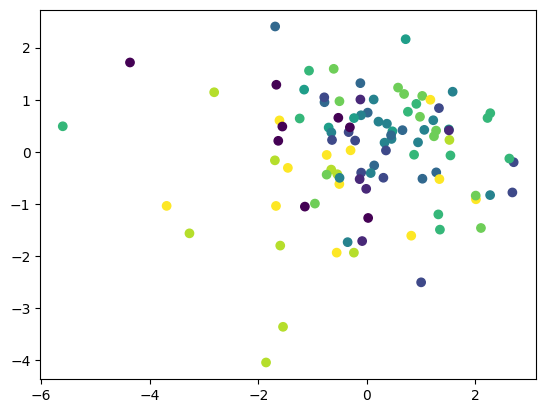

In [352]:
plt.scatter(x=x_pca[:, 0], y=x_pca[:, 1], c=y.cpu())